In [27]:
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [9]:
data = pickle.load(open('data.p', 'rb'))
print(data)

[{'date': datetime.date(2017, 10, 27), 'btc_tx_volume': 9780217059.503008, 'btc_mktcap': 98233030896.0, 'btc_usd': 5899.74, 'btc_exchange_volume': 1710130048.0, 'eth_tx_volume': 3150264533.0124774, 'eth_mktcap': 28276657471.32553, 'eth_usd': 296.51, 'eth_exchange_volume': 257168991.99999997, 'ltc_tx_volume': 173006316.35733452, 'ltc_mktcap': 2982126709.483282, 'ltc_usd': 55.67, 'ltc_exchange_volume': 78923104.0, 'xrp_tx_volume': 25133671.195290733, 'xrp_mktcap': 7847641468.86683, 'xrp_usd': 0.203668, 'xrp_exchange_volume': 29623000.000000004}, {'date': datetime.date(2017, 10, 28), 'btc_tx_volume': 6965317470.543407, 'btc_mktcap': 96375664793.26253, 'btc_usd': 5787.82, 'btc_exchange_volume': 1403920000.0, 'eth_tx_volume': 3838503881.1715865, 'eth_mktcap': 28416724623.16301, 'eth_usd': 297.92, 'eth_exchange_volume': 264424000.0, 'ltc_tx_volume': 154701105.692616, 'ltc_mktcap': 2967543021.283599, 'ltc_usd': 55.38, 'ltc_exchange_volume': 71063200.0, 'xrp_tx_volume': 13598142.873489503, 'xr

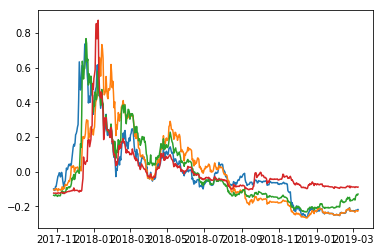

In [10]:
# plot price data

dates = [x['date'] for x in data]
prices_ = [{k:v for k,v in x.items() if k in ['btc_usd', 'eth_usd', 'ltc_usd', 'xrp_usd']} for x in data]
prices = pd.DataFrame(prices_, index = dates)
prices_norm = (prices - prices.mean()) / (prices.max() - prices.min())
plt.plot(prices_norm)

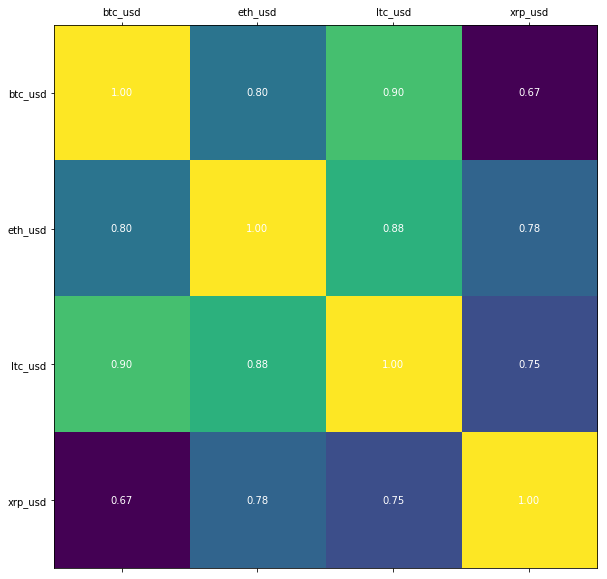

In [11]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    # Loop over data dimensions and create text annotations.
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            ax.text(j, i, '{:0.2f}'.format(corr.iloc[i, j]), ha="center", va="center", color="w")

plot_corr(prices)

In [12]:
def window_corr(df, window_size = 16):
    '''Generate sliding window correlation matrix
    
    Returns [(window_end_date, window_correlation_matrix)]'''
    corrs = []
    (rows, cols) = df.shape
    for i in range(rows-window_size):
        window = df[i:i+window_size]
        corrs.append((df.index[i+window_size-1], window.corr()))
    return corrs

x = window_corr(prices)
print(x)

[(datetime.date(2017, 11, 11),           btc_usd   eth_usd   ltc_usd   xrp_usd
btc_usd  1.000000  0.108048  0.331715  0.477740
eth_usd  0.108048  1.000000  0.652690  0.589059
ltc_usd  0.331715  0.652690  1.000000  0.887789
xrp_usd  0.477740  0.589059  0.887789  1.000000), (datetime.date(2017, 11, 12),           btc_usd   eth_usd   ltc_usd   xrp_usd
btc_usd  1.000000 -0.025190  0.207364  0.427037
eth_usd -0.025190  1.000000  0.702360  0.603912
ltc_usd  0.207364  0.702360  1.000000  0.877618
xrp_usd  0.427037  0.603912  0.877618  1.000000), (datetime.date(2017, 11, 13),           btc_usd   eth_usd   ltc_usd   xrp_usd
btc_usd  1.000000 -0.135043  0.097332  0.484852
eth_usd -0.135043  1.000000  0.702330  0.511479
ltc_usd  0.097332  0.702330  1.000000  0.780654
xrp_usd  0.484852  0.511479  0.780654  1.000000), (datetime.date(2017, 11, 14),           btc_usd   eth_usd   ltc_usd   xrp_usd
btc_usd  1.000000 -0.282074 -0.045651  0.471502
eth_usd -0.282074  1.000000  0.718567  0.426328
ltc_usd -

In [70]:
def execute_orders(fees, prices, balances, orders):
    for (pair, size) in orders.items():
        # hacky...
        currency = pair.partition("_")[0]
        balances['usd'] -= size
        balances[currency] += size / prices[pair]

def pnl(balances, prices):
    usd = 0
    for (currency, qty) in balances.items():
        if currency == 'usd':
            usd += qty
        else:
            pair = currency + '_usd'
            usd += qty * prices[pair]
    return usd

def evaluate(strategy, data, fees = 0):
    '''data is prices per-day'''
    balances = { 'usd': 0, 'btc': 0, 'eth': 0, 'ltc': 0, 'xrp': 0 }
    for (date, prices) in data.iterrows():
        orders = strategy.step(balances, prices)
        execute_orders(fees, prices, balances, orders)
    final_prices = data.iloc[-1]
    return { 'final_balances': balances, 'pnl': pnl(balances, final_prices) }

In [71]:
from strategy import Strategy, HoldStrategy

print(evaluate(HoldStrategy(), prices))

{'final_balances': {'usd': 0, 'btc': 0.0, 'eth': 0.0, 'ltc': 0, 'xrp': 0}, 'pnl': 0.0}


In [121]:
from collections import deque

class S(Strategy):
    def __init__(self, window_size = 64, min_edge = 0.00, max_edge = 0.1, size = 1000):
        '''size is usd per pct edge'''
        self.window = deque()
        self.window_size = window_size
        self.min_edge = min_edge
        self.max_edge = max_edge
        self.size = size
        
    def step(self, balances, prices):
        self.window.append(prices)
        while len(self.window) > self.window_size:
            self.window.popleft()
        if len(self.window) < self.window_size:
            return {}
        windowframe = pd.DataFrame(self.window)
        
        # Calaculates fair movements by averaging correlated movements between all pairs, weighted by r^2
        # Concretely:
        # fair_btc_movement =
        #   (btc_movment
        #    + eth_movement * r_eth^3
        #    + ltc_movement * r_ltc^3
        #    + xrp_movement * r_xrp^3)
        #   / (1 + r_eth^2 + r_ltc^2 + r_xrp^2)
        
        corr = windowframe.corr()
        movements = prices - windowframe.iloc[-2]
        pct_movements = (prices - windowframe.iloc[-2]) / windowframe.mean()
        predicted_pct_movements = pct_movements * corr
        confidences = corr ** 2
        fair_pct_movements = (predicted_pct_movements * confidences).sum(axis=1) / confidences.sum(axis=1)
        fairs = (fair_pct_movements + 1) * windowframe.mean()
        
#         print(corr, pct_movements)
#         print(predicted_pct_movements)
#         print(confidences)
#         print(pct_movements, fair_pct_movements)
#         print('')
#         print('pct_movements')
#         print(pct_movements)
#         print('fair_pct_movements')
#         print(fair_pct_movements)
        orders = {}
        for pair in pct_movements.index:
            delta = pct_movements[pair] - fair_pct_movements[pair]
            # this is super unsophisticated...
            if abs(delta) >= self.min_edge and abs(delta) < self.max_edge:
                orders[pair] = delta * 100 * self.size
        return orders

print(evaluate(S(), prices))

{'final_balances': {'usd': 177473.51369405043, 'btc': -4.294719895461183, 'eth': -182.37770163786644, 'ltc': -179.37502581304489, 'xrp': -73041.52900021592}, 'pnl': 101862.81552142903}
